# Monte Carlo simulations in a model for binary alloys

Coating a material with a thin layer of vaporized metal is a technique that is widely used in various industries. If the vapor consists of two types of metal atoms, then these are expected to mix and form an alloy. However, this is not always what happens. Sometimes, a phase separation happens on the surface of the growing layer of metal. This depends on several conditions: the temperature, the concentration of the metal vapor, and the strength of the bonds between atoms. The goal of this analysis is to use a simplified model of the physical process and predict whether the metals mix or not. This is done using a Monte Carlo simulation, showcasing the predictive strength of such simulations. Once the process has been simulated, we will analyze the correlation between the elapsed time and the degree of phase separation.

We choose to limit the surface of the metal coating to only a L-by-L grid with helical boundary conditions. At each location on the grid, the atom could either be of type A or type B. Two types of actions can occur: a new atom could condense onto the grid, burying the atom that was previously there underneath it, or an atom on the surface of the grid could move to an adjacent position due to its thermal energy. A second simplification we make is that the atoms undergo only nearest neighbor interactions. Any other interactions are much weaker and can be ignored within the relevant range of conditions. Helical boundary conditions allow for using only a single coordinate to characterize the surface of the lattice, which improves computation speed.

Which action occurs at any given time is completely random. One could ask how it is possible to predict anything when the process is statistical in nature. The answer is that we can let the system evolve for a very long time. Each individual step is random, but over time the system will evolve towards the most favorable configuration. This is what makes Monte Carlo simulations so powerful. They do not give you the exact answer, but they instead explore the space of possibilities and converge towards the exact answer while also keeping the computation time to a minimum.

Limiting the surface to only a L-by-L grid makes the algorithm unrealistic for large cluster sizes. However, as long as the clusters are much smaller than L<sup>2</sup>, the clusters behave the same way as if they were part of an infinite grid and thus the results of the algorithm are reliable.

## Details of the simulation process

Before heading into the python code, it is helpful to first specify how the simulation process works. The growing layer of metal is a three-dimensional grid like in the following figure. Atoms of type A are represented by white cubes, atoms of type B are represented by gray cubes. At the start of the simulation, only the bottom layer is filled. The bottom layer cannot be changed during the simulation. As the simulation progresses, new atoms are added from the top, creating a complex stack of blocks as is seen in the figure. It is important to know that only the top atoms are able to move. An atom with another atom on top of it cannot move. When we talk about the surface, we mean only the top atoms: the atoms that are visible when looking at the grid from above. The entire grid has helical boundary conditions in the horizontal directions.

![fig1](diagram_1.png)

The first type of action that can occur is that a new atom condenses onto the lattice. The location and atom type are chosen randomly, with each possibility being equally likely. This action is shown in the following figure.

![fig1](diagram_2.png)

The second type of action that can occur is a diffusion attempt. A diffusion attempt selects a random location on the surface of the grid, with each of the L<sup>2</sup> possible locations being equally likely. The atom in that location then has a certain chance to move to one of the four neighboring locations on the surface. A visual example of this process is provided by the following two figures.

![fig1](diagram_3.png)
![fig1](diagram_4.png)

The chance with which an atom is able to move during a diffusion attempt is found by calculating the total strength of the bonds with its neighboring atoms and taking an exponential function. This is a result that is explained by the field of statistical mechanics. There exist various tricks to implement this in a Monte Carlo simulation as efficiently as possible. For example, we can make sure that the function `numpy.exp` is only used once, at the very beginning of the simulation, instead of having to use this function with every diffusion attempt. This is a major time save.

## Setting up the simulation

The following block of Python code defines a function that keeps track of where every atom is. The function updates the locations of its atoms in accordance with the above stated rules. Each individual action involves only one atom, but the point of a Monte Carlo algorithm is that many many actions are performed in a chain. This way, complex behaviors can be modeled with only simple rules and minimal computation time.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats

In [2]:
def binary_film(DF, L, n, Jaa, Jab, random_start):
    # This function simulates the growth of an alloy crystal with a constant incoming flux
    #   of the two particle types, which we call A and B, in equal concentration.
    # Input:
    #   DF is the ratio of diffusion attempts per new incoming particle.
    #   L is the length and width of the lattice. The full lattice is 3-dimensional
    #       but diffusion and deposition of new particles happen only on the surface
    #       and the surface is a L-by-L lattice with helical boundary conditions.
    #   n is the maximum number of events that the simulation runs for, where an event
    #       can be either a diffusion attempt or the deposition of a new particle.
    #   Jaa is the energy per bond of same type nearest neighbors,
    #       divided by the temperature and by the Boltzmann constant.
    #   Jab is the energy per bond of different type nearest neighbors,
    #       divided by the temperature and by the Boltzmann constant.
    #   random_start is a boolean: if TRUE then the zeroth layer of particles is randomly generated,
    #       if FALSE then the zeroth layer consists of only A particles.
    # Output:
    #   snapshots is a list of surface configurations at specific times.
    #   snapshot_times is a list of 40 times at which a snapshot is taken.
    N = L**2
    rng = np.random.rand(4*n + N)           # all random numbers already generated at the start for speed
    diffuse_options = [1, L, -1, -L]        # to obtain nearest neighbors of a location x
    tau = 1 / (1 + DF)
    P_aa = np.exp(-Jaa)
    P_ab = np.exp(-Jab)
    max_h = 10 * round(n*tau/N)              # expected height for the crystal to grow, multiplied by 10

    h = [0 for x in range(N)]               # list of heights for each location x on the surface of the crystal
    psi = [[0 for y in range(max_h)] for x in range(N)]   # all lattice locations, still empty at the moment
    
    if random_start == True:
        for x in range(N):
            r = rng[-x]
            psi[x][0] = 2 * round(r) - 1    # random start layer: 1 corresponds to type A atoms,
                                            #   -1 corresponds to type B atoms, and 0 corresponds to nothing
    else:
        for x in range(N):
            psi[x][0] = 1                   # start layer with only type A atoms

    snapshots = []
    snapshot_times = [round(n / (1.1**k)) for k in np.flip(range(40))]      # 40 times that are
                                            #   equally spaced on a logarithmic plot
    
    t = 0
    while t < n and max(h) < max_h-1:
        if t in snapshot_times:             # add a snapshot of the surface
            new_snapshot = [[0 for i in range(L)] for j in range(L)]
            for i in range(L):
                for j in range(L):
                    x = L*i + j
                    new_snapshot[i][j] = psi[x][h[x]]
            snapshots.append(new_snapshot)
        
        r = rng[4*t]
        x = int(r * N)                      # randomly select a location

        r = rng[4*t+1]
        if r < tau:                         # select whether a particle is added or a surface particle diffuses
            h[x] += 1
            r = rng[4*t+2]
            psi[x][h[x]] = 2*round(r) - 1   # select whether the added particle is of type A or B
        
        else:
            if h[x] > 0:                    # start layer particles are not allowed to move
                neighbours = [0] * 5
                
                neighbours[0] = psi[x][h[x]] * psi[x][h[x]-1]
                neighbours[1] = psi[x][h[x]] * psi[np.mod(x + 1, N)][h[x]]
                neighbours[2] = psi[x][h[x]] * psi[np.mod(x + L, N)][h[x]]
                neighbours[3] = psi[x][h[x]] * psi[np.mod(x - 1 + N, N)][h[x]]
                neighbours[4] = psi[x][h[x]] * psi[np.mod(x - L + N, N)][h[x]]
                sum_1 = sum([abs(x) for x in neighbours])
                sum_2 = sum(neighbours)
                N_same = (sum_1 + sum_2) / 2        # number of same type nearest neighbors
                N_different = (sum_1 - sum_2) / 2   # number of different type nearest neighbors
                P = P_aa**N_same * P_ab**N_different    # diffusion probability
                
                r = rng[4*t+2]
                if r < P:                   # check whether diffusion is successful
                    r = rng[4*t+3]
                    dx = diffuse_options[int(4 * r)]    # select neighbouring location
                    x_new = np.mod(x + dx + N, N)
                    h[x_new] += 1                       # the particle moves on top of the new location
                    psi[x_new][h[x_new]] = psi[x][h[x]]
                    psi[x][h[x]] = 0
                    h[x] -= 1
        t += 1
    
    snapshot_times = snapshot_times[:len(snapshots)]
    return snapshots, snapshot_times

When carrying out the simulation, we keep a series of snapshots of how the surface looks like at specific times. What interests us about these snapshots is how the type A and type B atoms are distributed. Are they all clumped together into clusters or not? How does the size of the clusters evolve over time? To answer these questions, we need to compute how many clusters there are in each individual snapshot. This is exactly what the next python function does.

In [3]:
def cluster_number(snapshot):
    # This function takes a snapshot from the previous function as input and finds how many
    #   clusters are present. It does this using two lists: unsearched and searched. For every
    #   coordinate in unsearched, the nearest neighbors are investigated. The coordinates of
    #   its nearest neighbors with the same particle type are put in unsearched as well. Once its
    #   nearest neighbors have been investigated, this coordinate is moved to searched. The number
    #   of times that this process has to run to cover the entire surface is the number of clusters.
    L = len(snapshot[0])
    N = L**2
    clusters = 0
    
    x = 0                                   # starting coordinate for finding clusters
    while x < N:
        unsearched = [x]
        searched = []
        while len(unsearched) > 0:          # as long as unsearched isn't empty, there's still part of
                                            #   the cluster left to map out
            x = unsearched[0]
            for dx in [1, L, -1, -L]:       # loop over nearest neighbours
                x_new = np.mod(x + dx + N, N)
                if (x_new not in unsearched) and (x_new not in searched):
                    value = snapshot[x // L][np.mod(x, L)]
                    neighbour_value = snapshot[x_new // L][np.mod(x_new, L)]
                    if value == neighbour_value:
                        unsearched.append(x_new)
            searched.append(x)
            del unsearched[0]
            snapshot[x // L][np.mod(x, L)] = 0      # checked clusters are put to zero
        
        clusters += 1
        x = 0
        while x < N and snapshot[x // L][np.mod(x, L)] == 0:
            x += 1                          # a nonzero value is looked for to be the next starting coordinate
    return clusters

## Results of the experiment

Now that the most important code has been written, we can proceed with actually performing a Monte Carlo experiment. For four snapshots, a diagram shows how the surface of the growing binary crystal looks like. Type A atoms are shown using black squares and type B atoms are shown using white squares.

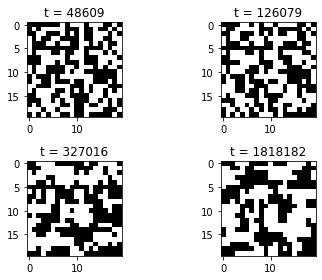

In [4]:
L=20
snapshots, snapshot_times, = binary_film(DF=500, L=L, n=2000000, Jaa=2, Jab=0.4, random_start=True)

plt.figure(1)
plt.subplot(221)
plt.imshow(snapshots[0], cmap='Greys')
plt.title('t = ' + str(int(snapshot_times[0])))

plt.subplot(222)
plt.imshow(snapshots[10], cmap='Greys')
plt.title('t = ' + str(int(snapshot_times[10])))

plt.subplot(223)
plt.imshow(snapshots[20], cmap='Greys')
plt.title('t = ' + str(int(snapshot_times[20])))

plt.subplot(224)
plt.imshow(snapshots[-1], cmap='Greys')
plt.title('t = ' + str(int(snapshot_times[-1])))

plt.tight_layout()
plt.show()

The surface of the binary film has changed substantially in between the snapshots. This tells us that enough time steps have passed in the Monte Carlo simulation in order for its results to be reliable. We can definitely see the formation of large clusters happening. The following analysis quantifies this growth.

The number of clusters can be counted and from this the average cluster size can be calculated. The following plot puts the average cluster size in function of the time, using a logarithmic scale on the horizontal axis.

In [5]:
A = [0 for i in snapshots]
for i in range(len(snapshots)):
    A[i] = L**2 / cluster_number(snapshots[i])      # average cluster area

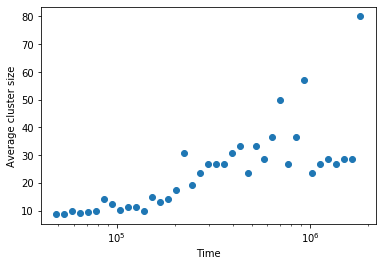

In [6]:
plt.figure(2)
plt.plot(snapshot_times, A, 'o')
plt.xscale("log")
plt.xlabel('Time')
plt.ylabel('Average cluster size')
plt.show()

The reasoning behind the time axis having a logarithmic scale is the following: it is easier to merge clusters together when these are smaller. The larger the average cluster size, the more time it takes to merge clusters together. Without the logarithmic scale, the plot would only focus on the time scales when the average cluster size is already large. By having the data points be equally spaced on a logarithmic plot, we are also able to learn about the time scales when the clusters are still small.

There are two phases in this plot. During the first phase, the average cluster size is small and barely grows at all. Not enough time steps have passed yet in order for the Monte Carlo simulation to thoroughly explore the space of possible configurations. Only with a large number of time steps can the simulation find the most optimal configuration.

The second phase in the plot is when the average cluster size is growing the most and its variance increases. The reason why the variance increases is because, the bigger clusters get, the more likely it is that a newly condensed atom finds itself surrounded by atoms of a different type. The condensation of a new atom onto the lattice is much more likely to change the number of clusters when most clusters are large.

The two phases together form a rising trend. The presence of these two phases in the plot proves that there is cluster formation. We can increase the temperature and see what the effect is. Increasing the temperature means decreasing `Jaa` and `Jab`.

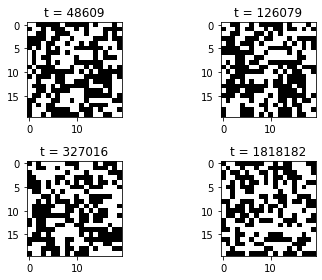

In [7]:
snapshots, snapshot_times, = binary_film(DF=500, L=L, n=2000000, Jaa=0.5, Jab=0.1, random_start=True)

plt.figure(3)
plt.subplot(221)
plt.imshow(snapshots[0], cmap='Greys')
plt.title('t = ' + str(int(snapshot_times[0])))

plt.subplot(222)
plt.imshow(snapshots[10], cmap='Greys')
plt.title('t = ' + str(int(snapshot_times[10])))

plt.subplot(223)
plt.imshow(snapshots[20], cmap='Greys')
plt.title('t = ' + str(int(snapshot_times[20])))

plt.subplot(224)
plt.imshow(snapshots[-1], cmap='Greys')
plt.title('t = ' + str(int(snapshot_times[-1])))

plt.tight_layout()
plt.show()

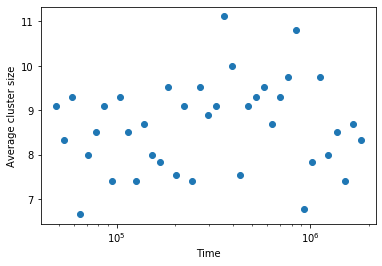

In [8]:
A = [0 for i in snapshots]
for i in range(len(snapshots)):
    A[i] = L**2 / cluster_number(snapshots[i])      # average cluster area

plt.figure(4)
plt.plot(snapshot_times, A, 'o')
plt.xscale("log")
plt.xlabel('Time')
plt.ylabel('Average cluster size')
plt.show()

This time the temperature is 4 times higher. The same number of time steps have elapsed. However, the increasing trend in the plot is missing. The data points are scattered around an approximately constant value, without a rising trend. This suggests that there is no tendency to form clusters, at least not within the time frame of `n=2000000` time steps.

## Results

The temperature has an immense effect on the formation of clusters when growing a binary alloy in a thin coating layer. It can be expected that the other input parameters also have an important effect. The Monte Carlo simulation used in this analysis is able to predict whether the atoms of the alloy are able to mix.